<a href="https://colab.research.google.com/github/owlc33k/jupyter-notebook/blob/master/vgg16_tl_CJL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Driveのパスをマウント

from google.colab import drive
import os
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# 呼び出しやすいようにPathを設定

import os
base_path = "/content/drive/My Drive/data/CJL/".replace('/', os.sep)

In [0]:
# 必要なライブラリをインポート

import glob
import cv2
import math
import pandas as pd
import numpy as np

from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

%matplotlib inline

In [65]:
# ラベルと画像をフォルダから読み込む
df = []
for foldername in os.listdir(base_path):
    imgs_path = base_path + foldername
    imgs = sorted(glob.glob(imgs_path + "/" + '*.jpg'))
    
    for name in imgs:
        df.append((str(name), str(foldername)))

# データフレームへ格納
df = pd.DataFrame(df, columns=['Image', 'Label'], index=None)

# 初めの5個のデータの確認
df.head()

,Image,Label
0,/content/drive/My Drive/data/CJL/Cheetah/00000...,Cheetah
1,/content/drive/My Drive/data/CJL/Cheetah/00000...,Cheetah
2,/content/drive/My Drive/data/CJL/Cheetah/00000...,Cheetah
3,/content/drive/My Drive/data/CJL/Cheetah/00000...,Cheetah
4,/content/drive/My Drive/data/CJL/Cheetah/00000...,Cheetah


In [68]:
# データ数
print(len(df))

257


In [69]:
# データフレームをラベル毎に学習用と検証用に8:2に分割

train_df = pd.DataFrame(columns=['Image', 'Label'], index=None)
val_df = pd.DataFrame(columns=['Image', 'Label'], index=None)
labels = df['Label'].unique()

for label in labels:
  temp_df = df[df['Label'] == label]
  split = math.floor(len(temp_df) * 0.8)
  train_df = pd.concat([train_df, temp_df[0:split]])
  val_df = pd.concat([val_df, temp_df[split:]])

print(train_df.shape)
print(val_df.shape)

(204, 2)
(53, 2)


In [0]:
# データのシャッフル
train_df = train_df.sample(frac=1.,random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=1.,random_state=42).reset_index(drop=True)

In [71]:
# 訓練データの読み込みと前処理
img_list = []
imgs = []

# 各画像を読み込んで前処理を加える
for i in range(len(train_df)):
    # 画像の読み込み
    imgs = cv2.imread(train_df['Image'][i],1)
    # 画像のリサイズ（224, 224）
    imgs = cv2.resize(imgs, (224, 224))
    # 画像の正規化
    imgs = imgs.astype('float32') /255
    # リストへ追加
    img_list.append(imgs)
    
# リストからNumpy配列へ変換
X_train = np.array(img_list)

# サイズを確認
X_train.shape

(204, 224, 224, 3)

In [72]:
# valデータの読み込みと前処理
img_list = []
imgs = []

# 各画像を読み込んで前処理を加える
for i in range(len(val_df)):
    # 画像の読み込み
    imgs = cv2.imread(val_df['Image'][i],1)
    # 画像のリサイズ（224, 224）
    imgs = cv2.resize(imgs, (224, 224))
    # 画像の正規化
    imgs = imgs.astype('float32') /255
    # リストへ追加
    img_list.append(imgs)
    
# リストからNumpy配列へ変換
X_val = np.array(img_list)

# サイズを確認
X_val.shape

(53, 224, 224, 3)

In [0]:
# 反転等で学習用データを水増し
datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=5,
    zoom_range=0.1,
    horizontal_flip=True)

        
# 水増し画像を訓練用画像の形式に合わせる
datagen.fit(X_train)
datagen.fit(X_val)

In [0]:
# ラベルをダミー変数に変換

y_train = pd.get_dummies(train_df['Label']).values
y_val = pd.get_dummies(val_df['Label']).values

In [75]:
# ダミー変数の値はフォルダ名順になっている

print(y_val[0:5])
print(val_df[0:5])

[[0 0 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]]
                                               Image    Label
0  /content/drive/My Drive/data/CJL/Leopard/00009...  Leopard
1  /content/drive/My Drive/data/CJL/Jaguar/000115...   Jaguar
2  /content/drive/My Drive/data/CJL/Jaguar/000122...   Jaguar
3  /content/drive/My Drive/data/CJL/Cheetah/00011...  Cheetah
4  /content/drive/My Drive/data/CJL/Jaguar/000117...   Jaguar


In [76]:
# VGG16のモデルを出力部分を含まない状態で呼び出す
vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))

# モデルの最後が出力層を含まずプーリング層となっている
vgg16.summary()

W0614 05:49:49.357888 139771292555136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 05:49:49.406614 139771292555136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 05:49:49.414655 139771292555136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0614 05:49:49.463998 139771292555136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 3s 0us/step


W0614 05:49:52.970709 139771292555136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0614 05:49:52.971971 139771292555136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [77]:
# 呼び出したモデルを使った新しいモデル
model = Sequential(vgg16.layers)

# 第15層までの重みを固定
for layer in model.layers[:15]:
  layer.trainable = False

# プーリング層の多次元テンソルを2次元に展開し全結合層を追加。出力層のニューロン数は分類数と同じにする。
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# マルチクラス分類のため損失関数はcategorical
model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

model.summary()

W0614 05:50:43.702341 139771292555136 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0614 05:50:43.754154 139771292555136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [0]:
# 過学習の抑制

early_stopping = EarlyStopping(monitor='val_loss', patience=10 , verbose=1)

In [82]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                              samples_per_epoch=X_train.shape[0],
                              nb_epoch=100,
                              verbose=1,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stopping])

model.save(base_path + '/CJL.h5', include_optimizer=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., verbose=1, validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=3, epochs=100)`
  


Epoch 1/100
3/3 [==============================] - 3s 1s/step - loss: 1.1456 - acc: 0.4167 - val_loss: 0.9525 - val_acc: 0.5472
Epoch 2/100
3/3 [==============================] - 2s 677ms/step - loss: 0.8138 - acc: 0.6642 - val_loss: 0.8039 - val_acc: 0.6038
Epoch 3/100
3/3 [==============================] - 2s 729ms/step - loss: 0.7860 - acc: 0.6815 - val_loss: 0.8232 - val_acc: 0.6226
Epoch 4/100
3/3 [==============================] - 2s 729ms/step - loss: 0.8949 - acc: 0.5283 - val_loss: 0.8415 - val_acc: 0.5849
Epoch 5/100
3/3 [==============================] - 3s 923ms/step - loss: 0.8250 - acc: 0.6458 - val_loss: 0.8152 - val_acc: 0.6604
Epoch 6/100
3/3 [==============================] - 2s 731ms/step - loss: 0.8155 - acc: 0.5744 - val_loss: 0.7950 - val_acc: 0.6226
Epoch 7/100
3/3 [==============================] - 2s 722ms/step - loss: 0.8283 - acc: 0.5738 - val_loss: 0.7888 - val_acc: 0.6604
Epoch 8/100
3/3 [==============================] - 2s 769ms/step - loss: 0.7131 - acc:

In [0]:
#model.save(base_path + '/CJL.h5', include_optimizer=False)

In [0]:
'''#import json

# モデルの保存
with open(base_path + 'CJL.json',"w") as f:
  json.dump(model.to_json(), f)

# 学習済みの重みを保存
model.save_weights(base_path + 'CJL.hdf5')'''

In [115]:
'''from keras.models import model_from_json
# モデルの読み込み
#model2 = model_from_json(open(base_path + 'CJL.json', 'r').read())

# 重みの読み込み
#model2.load_weights(base_path + 'CJL.hdf5')'''

ValueError: ignored

In [110]:
#from keras.models import load_model
#model2 = load_model(base_path + '/CJL.h5')

ValueError: ignored

In [102]:
# データの読み込み
test_df = []
imgs = sorted(glob.glob("/content/drive/My Drive/data/CJLtest/" + '*.jpg'))

for name in imgs:
    test_df.append((str(name)))

# データフレームへ格納
test_df = pd.DataFrame(test_df, columns=['Image'], index=None)
test_df.head()

,Image
0,/content/drive/My Drive/data/CJLtest/cheetah1.jpg
1,/content/drive/My Drive/data/CJLtest/jaguar1.jpg
2,/content/drive/My Drive/data/CJLtest/jaguar2.jpg
3,/content/drive/My Drive/data/CJLtest/leopard1.jpg
4,/content/drive/My Drive/data/CJLtest/leopard2.jpg


In [103]:
# 訓練データの読み込みと前処理
img_list = []
imgs = []

# 各画像を読み込んで前処理を加える
for i in range(len(test_df)):
    # 画像の読み込み
    imgs = cv2.imread(test_df['Image'][i],1)
    # 画像のリサイズ（224, 224）
    imgs = cv2.resize(imgs, (224, 224))
    # 画像の正規化
    imgs = imgs.astype('float32') /255
    # リストへ追加
    img_list.append(imgs)
    
# リストからNumpy配列へ変換
X_test = np.array(img_list)

# サイズを確認
X_test.shape

(5, 224, 224, 3)

In [0]:
# テスト画像毎に各カテゴリに属する確率を予測
prob = model.predict(X_test)

In [101]:
test_df['Image'][1].strip("/content/drive/My Drive/data/CJLtest/")

'jaguar1.jpg'

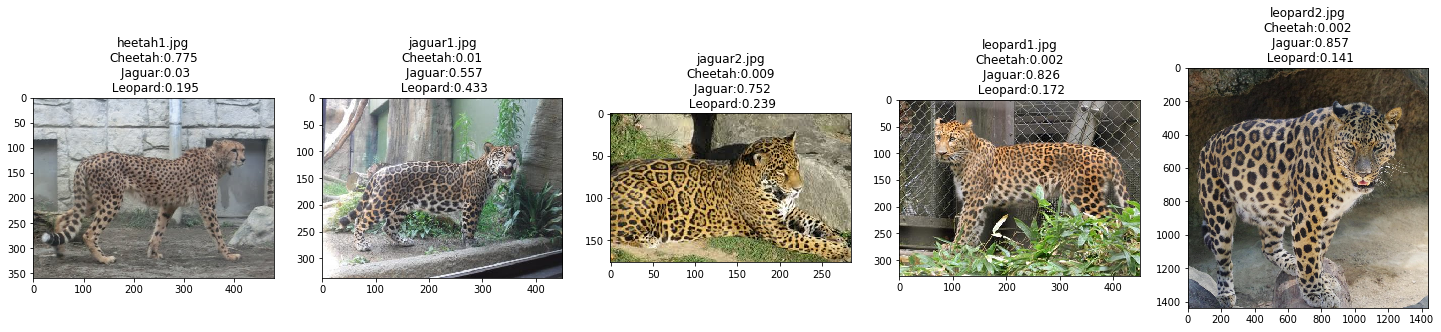

In [104]:
# テスト用画像が入ったフォルダから画像と予測結果を表示

fig, ax = plt.subplots(1, len(test_df), figsize=(25,6))

plot_number = 1
for i in range(len(test_df)): 
    image = cv2.imread(test_df['Image'].iloc[i],1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(1, len(test_df), plot_number)
    img_name = test_df['Image'][i].strip("/content/drive/My Drive/data/CJLtest/")
    title = img_name + "\nCheetah:" + str(round(prob[i][0], 3)) + "\n Jaguar:" + str(round(prob[i][1], 3))  + "\n Leopard:" + str(round(prob[i][2], 3)) 
    plt.imshow(image)
    plt.title(title)
    plot_number = plot_number+1

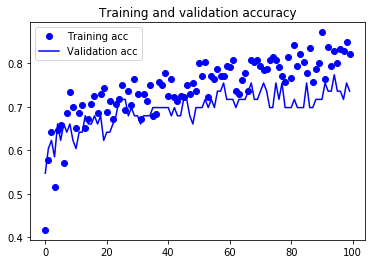

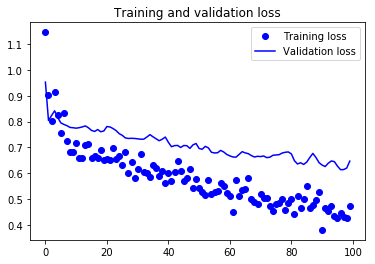

In [105]:
# 高バリアンスのため学習用データをもっと集める必要がある

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
